# Demo of Ch6. Generative Adversarial Network
----
This is the sample code of TU-ETP-AD1062 Machine Learning Fundamentals.

For more information, please refer to:
https://sites.google.com/view/tu-ad1062-mlfundamentals/

## Import Packages
----

In [20]:
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D, Reshape, Flatten, BatchNormalization
from keras.optimizers import RMSprop
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from keras.datasets import mnist
from keras.datasets import fashion_mnist

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

%matplotlib inline

## Load Dataset
----

Image shape: (60000, 28, 28)
Vectorized image shape: (60000, 784)


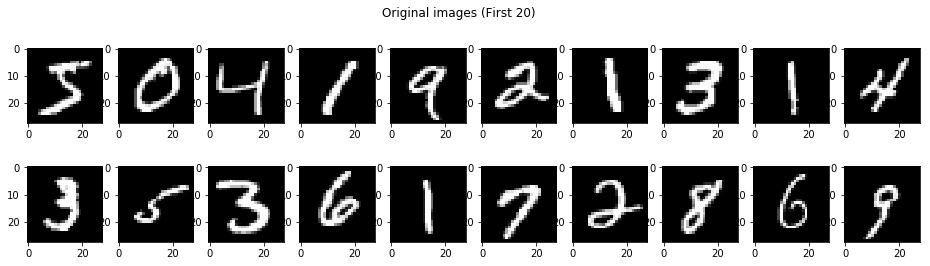

In [3]:
(I_train, y_train), (I_test, y_test) = mnist.load_data()

I_train = np.array(I_train) / 255.0
y_train = np.array(y_train)

I_test = np.array(I_test) / 255.0
y_test = np.array(y_test)
print('Image shape: %s' % (I_train.shape, ))

X_train = I_train.reshape((len(I_train), np.prod(I_train.shape[1:])))
X_test = I_test.reshape((len(I_test), np.prod(I_test.shape[1:])))
print('Vectorized image shape: %s' %(X_train.shape, ))

plt.figure(figsize=(16, 4))
plt.suptitle('Original images (First 20)')
for i in range(0,20):
    plt.subplot(2, 10, i+1)
    plt.imshow(I_train[i,:], cmap='gray')

## 6.1. Auto-encoder

Reference: https://blog.keras.io/building-autoencoders-in-keras.html

### Demo 6.1.1. Auto-Encoder
---

In [ ]:
encoding_dim = 2

def build_autoencoder():
    input_img = Input(shape=(784,))
    
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)

    # Auto-Encoder
    autoencoder = Model(input_img, decoded)

    # Encoder
    encoder = Model(input_img, encoded)

    # Decoder
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder, encoder, decoder

In [ ]:
autoencoder, encoder, decoder = build_autoencoder()
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

In [ ]:
encoded_imgs = encoder.predict(X_train)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(16, 4))
plt.suptitle('Original images')
for i in range(0,20):
    plt.subplot(2, 10, i+1)
    plt.imshow(I_train[i,:], cmap='gray')

plt.figure(figsize=(16, 4))
plt.suptitle('Generated images')
for i in range(0,20):
    plt.subplot(2, 10, i+1)
    plt.imshow(decoded_imgs[i,:].reshape(28, 28), cmap='gray')

### Demo 6.1.2. Auto-Encoder with Convolutional Layer
---

In [ ]:
encoding_dim = 2

def build_cnn_autoencoder():
    input_img = Input(shape=(28, 28 ,1))
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Dense(encoding_dim, activation='relu')(x)
    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) 
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    display(autoencoder.summary())
    
    return autoencoder

In [ ]:
I_train = I_train.reshape( (len(I_train), 28, 28, 1) )
I_test = I_test.reshape( (len(I_test), 28, 28, 1) )

autoencoder_cnn = build_cnn_autoencoder()
autoencoder_cnn.fit(I_train, I_train,
                    epochs=10,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(I_test, I_test))
autoencoder_cnn.save('data/demo6/autoencoder_cnn_dim2.h5')

In [ ]:
I_train_predict = autoencoder_cnn.predict(I_train)

In [ ]:
plt.figure(figsize=(16, 4))
plt.suptitle('Original images')
for i in range(0,20):
    plt.subplot(2, 10, i+1)
    plt.imshow(I_train[i,:].reshape(28, 28), cmap='gray')

plt.figure(figsize=(16, 4))
plt.suptitle('Generated images')
for i in range(0,20):
    plt.subplot(2, 10, i+1)
    plt.imshow(I_train_predict[i,:].reshape(28, 28), cmap='gray')

### Demo 6.1.3. Auto-Encoder with Convolutional Layer
---
##### `__sampling(z_mean, z_log_var)`
Function used for reparameterization Trick, which samples a random varaible $\epsilon$ (i.e., local variable `epsilon`), then added it into mean value:
$$z = \overline{z} + \sigma \odot \epsilon$$, 
where $\epsilon=\mathcal{N}\left(0,I \right)$

In [7]:
class VAE:
    def __init__(self, original_dim):
        self._input_shape = (original_dim, )
        self._latent_dim = 2
        
        self._model = None
        
        self._encoder = None
        self._decoder = None
        
        self.create_VAE()
    
    
    @staticmethod
    def __sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
    def create_VAE(self):
        # Encoder
        inputs = Input(shape=self._input_shape, name='encoder_input')
        
        x = Dense(512, activation='relu')(inputs)
        
        z_mean    = Dense(self._latent_dim, name='z_mean')(x)
        z_log_var = Dense(self._latent_dim, name='z_log_var')(x)
        z         = Lambda(VAE.__sampling, output_shape=(self._latent_dim,), name='z')([z_mean, z_log_var])
        
        self._encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        self._encoder.summary()
        
        # Decoder
        latent_inputs = Input(shape=(self._latent_dim,), name='z_sampling')
        x = Dense(512, activation='relu')(latent_inputs)
        outputs = Dense(self._input_shape[0], activation='sigmoid')(x)
        
        self._decoder = Model(latent_inputs, outputs, name='decoder')
        self._decoder.summary()
        
        # Define loss
        reconstruction_loss = binary_crossentropy(inputs, outputs)

        reconstruction_loss *= self._input_shape[0]
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        loss = K.mean(reconstruction_loss + kl_loss)
        
        # instantiate VAE model
        outputs = self._decoder(self._encoder(inputs)[2])
        
        self._model = Model(inputs, outputs, name='vae_mlp')
        self._model.add_loss(loss)
        self._model.compile(optimizer='adam')
        self._model.summary()
        
        
    def fit(self, X_train, epochs=20, batch_size=64, validation_data=None):
        self._model.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        self._model.save('data/demo6/model_vae.h5')
        
    def predict(self, X_test):
        return self._model(X_test)

In [6]:
vae = VAE(original_dim=X_train.shape[1])
vae.fit(X_train=X_train, epochs=10, batch_size=64, validation_data=(X_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_7[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_7[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

InvalidArgumentError: You must feed a value for placeholder tensor 'z_sampling_2' with dtype float and shape [?,2]
	 [[{{node z_sampling_2}} = Placeholder[dtype=DT_FLOAT, shape=[?,2], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

if __name__ == '__main__':
    models = (encoder, decoder)
    data = (x_test, y_test)
    reconstruction_loss = binary_crossentropy(inputs, outputs)

    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    plot_model(vae,
               to_file='vae_mlp.png',
               show_shapes=True)

    
    vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
    vae.save_weights('vae_mlp_mnist.h5')

    plot_results(models, data, batch_size=batch_size, model_name="vae_mlp")

In [ ]:
plot_results(models, data, batch_size=batch_size, model_name="vae_mlp")

In [17]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("data/demo6/GAN/%d.png" % epoch)
        plt.close()



In [18]:
gan = GAN()
gan.train(epochs=30000, batch_size=32, sample_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

18400 [D loss: 0.738544, acc.: 56.25%] [G loss: 1.110454]
18600 [D loss: 0.607316, acc.: 62.50%] [G loss: 0.955649]
18800 [D loss: 0.653240, acc.: 65.62%] [G loss: 0.957616]
19000 [D loss: 0.620945, acc.: 71.88%] [G loss: 0.990155]
19200 [D loss: 0.657948, acc.: 70.31%] [G loss: 0.991224]
19400 [D loss: 0.639831, acc.: 60.94%] [G loss: 1.019507]
19600 [D loss: 0.651740, acc.: 64.06%] [G loss: 1.007610]
19800 [D loss: 0.609737, acc.: 59.38%] [G loss: 0.915603]
20000 [D loss: 0.646434, acc.: 53.12%] [G loss: 1.020977]
20200 [D loss: 0.635912, acc.: 67.19%] [G loss: 1.099247]
20400 [D loss: 0.630495, acc.: 57.81%] [G loss: 1.000307]
20600 [D loss: 0.560572, acc.: 64.06%] [G loss: 1.127739]
20800 [D loss: 0.720014, acc.: 51.56%] [G loss: 0.954316]
21000 [D loss: 0.563333, acc.: 75.00%] [G loss: 0.964737]
21200 [D loss: 0.688827, acc.: 60.94%] [G loss: 1.062248]
21400 [D loss: 0.554261, acc.: 68.75%] [G loss: 1.036725]
21600 [D loss: 0.615255, acc.: 64.06%] [G loss: 0.943368]
21800 [D loss:

In [21]:
import sys

import numpy as np

class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("data/demo6/WGAN/mnist_%d.png" % epoch)
        plt.close()


wgan = WGAN()
wgan.train(epochs=4000, batch_size=32, sample_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 8, 8, 32)          0         
__________

87 [D loss: 0.999969] [G loss: 1.000132]
88 [D loss: 0.999975] [G loss: 1.000126]
89 [D loss: 0.999966] [G loss: 1.000125]
90 [D loss: 0.999978] [G loss: 1.000119]
91 [D loss: 0.999976] [G loss: 1.000121]
92 [D loss: 0.999972] [G loss: 1.000116]
93 [D loss: 0.999973] [G loss: 1.000130]
94 [D loss: 0.999977] [G loss: 1.000130]
95 [D loss: 0.999968] [G loss: 1.000137]
96 [D loss: 0.999962] [G loss: 1.000117]
97 [D loss: 0.999967] [G loss: 1.000118]
98 [D loss: 0.999974] [G loss: 1.000118]
99 [D loss: 0.999969] [G loss: 1.000117]
100 [D loss: 0.999970] [G loss: 1.000118]
101 [D loss: 0.999972] [G loss: 1.000119]
102 [D loss: 0.999969] [G loss: 1.000132]
103 [D loss: 0.999967] [G loss: 1.000110]
104 [D loss: 0.999970] [G loss: 1.000110]
105 [D loss: 0.999967] [G loss: 1.000117]
106 [D loss: 0.999975] [G loss: 1.000114]
107 [D loss: 0.999967] [G loss: 1.000095]
108 [D loss: 0.999959] [G loss: 1.000105]
109 [D loss: 0.999966] [G loss: 1.000107]
110 [D loss: 0.999972] [G loss: 1.000111]
111 [

283 [D loss: 0.999970] [G loss: 1.000069]
284 [D loss: 0.999971] [G loss: 1.000066]
285 [D loss: 0.999969] [G loss: 1.000075]
286 [D loss: 0.999969] [G loss: 1.000077]
287 [D loss: 0.999972] [G loss: 1.000068]
288 [D loss: 0.999972] [G loss: 1.000076]
289 [D loss: 0.999969] [G loss: 1.000067]
290 [D loss: 0.999974] [G loss: 1.000076]
291 [D loss: 0.999969] [G loss: 1.000065]
292 [D loss: 0.999969] [G loss: 1.000073]
293 [D loss: 0.999968] [G loss: 1.000074]
294 [D loss: 0.999972] [G loss: 1.000065]
295 [D loss: 0.999968] [G loss: 1.000072]
296 [D loss: 0.999968] [G loss: 1.000062]
297 [D loss: 0.999970] [G loss: 1.000072]
298 [D loss: 0.999969] [G loss: 1.000074]
299 [D loss: 0.999971] [G loss: 1.000065]
300 [D loss: 0.999970] [G loss: 1.000068]
301 [D loss: 0.999976] [G loss: 1.000055]
302 [D loss: 0.999972] [G loss: 1.000075]
303 [D loss: 0.999969] [G loss: 1.000068]
304 [D loss: 0.999966] [G loss: 1.000065]
305 [D loss: 0.999962] [G loss: 1.000060]
306 [D loss: 0.999972] [G loss: 1.

479 [D loss: 0.999970] [G loss: 1.000054]
480 [D loss: 0.999975] [G loss: 1.000063]
481 [D loss: 0.999963] [G loss: 1.000060]
482 [D loss: 0.999969] [G loss: 1.000064]
483 [D loss: 0.999968] [G loss: 1.000074]
484 [D loss: 0.999964] [G loss: 1.000065]
485 [D loss: 0.999970] [G loss: 1.000062]
486 [D loss: 0.999968] [G loss: 1.000064]
487 [D loss: 0.999973] [G loss: 1.000068]
488 [D loss: 0.999974] [G loss: 1.000070]
489 [D loss: 0.999966] [G loss: 1.000077]
490 [D loss: 0.999970] [G loss: 1.000072]
491 [D loss: 0.999970] [G loss: 1.000055]
492 [D loss: 0.999977] [G loss: 1.000063]
493 [D loss: 0.999969] [G loss: 1.000064]
494 [D loss: 0.999979] [G loss: 1.000076]
495 [D loss: 0.999974] [G loss: 1.000067]
496 [D loss: 0.999969] [G loss: 1.000072]
497 [D loss: 0.999966] [G loss: 1.000070]
498 [D loss: 0.999967] [G loss: 1.000056]
499 [D loss: 0.999967] [G loss: 1.000068]
500 [D loss: 0.999966] [G loss: 1.000071]
501 [D loss: 0.999972] [G loss: 1.000074]
502 [D loss: 0.999971] [G loss: 1.

675 [D loss: 0.999968] [G loss: 1.000064]
676 [D loss: 0.999962] [G loss: 1.000068]
677 [D loss: 0.999976] [G loss: 1.000054]
678 [D loss: 0.999967] [G loss: 1.000057]
679 [D loss: 0.999967] [G loss: 1.000062]
680 [D loss: 0.999976] [G loss: 1.000064]
681 [D loss: 0.999969] [G loss: 1.000060]
682 [D loss: 0.999970] [G loss: 1.000070]
683 [D loss: 0.999974] [G loss: 1.000076]
684 [D loss: 0.999974] [G loss: 1.000074]
685 [D loss: 0.999971] [G loss: 1.000066]
686 [D loss: 0.999970] [G loss: 1.000072]
687 [D loss: 0.999970] [G loss: 1.000060]
688 [D loss: 0.999970] [G loss: 1.000067]
689 [D loss: 0.999966] [G loss: 1.000070]
690 [D loss: 0.999978] [G loss: 1.000071]
691 [D loss: 0.999962] [G loss: 1.000073]
692 [D loss: 0.999974] [G loss: 1.000059]
693 [D loss: 0.999968] [G loss: 1.000069]
694 [D loss: 0.999973] [G loss: 1.000061]
695 [D loss: 0.999971] [G loss: 1.000066]
696 [D loss: 0.999973] [G loss: 1.000056]
697 [D loss: 0.999968] [G loss: 1.000071]
698 [D loss: 0.999968] [G loss: 1.

871 [D loss: 0.999970] [G loss: 1.000059]
872 [D loss: 0.999975] [G loss: 1.000053]
873 [D loss: 0.999967] [G loss: 1.000065]
874 [D loss: 0.999968] [G loss: 1.000058]
875 [D loss: 0.999968] [G loss: 1.000062]
876 [D loss: 0.999978] [G loss: 1.000061]
877 [D loss: 0.999966] [G loss: 1.000072]
878 [D loss: 0.999960] [G loss: 1.000068]
879 [D loss: 0.999975] [G loss: 1.000072]
880 [D loss: 0.999960] [G loss: 1.000056]
881 [D loss: 0.999971] [G loss: 1.000079]
882 [D loss: 0.999965] [G loss: 1.000054]
883 [D loss: 0.999974] [G loss: 1.000066]
884 [D loss: 0.999964] [G loss: 1.000065]
885 [D loss: 0.999967] [G loss: 1.000061]
886 [D loss: 0.999965] [G loss: 1.000069]
887 [D loss: 0.999970] [G loss: 1.000061]
888 [D loss: 0.999964] [G loss: 1.000066]
889 [D loss: 0.999970] [G loss: 1.000066]
890 [D loss: 0.999982] [G loss: 1.000064]
891 [D loss: 0.999972] [G loss: 1.000068]
892 [D loss: 0.999972] [G loss: 1.000057]
893 [D loss: 0.999973] [G loss: 1.000061]
894 [D loss: 0.999969] [G loss: 1.

1065 [D loss: 0.999969] [G loss: 1.000058]
1066 [D loss: 0.999973] [G loss: 1.000063]
1067 [D loss: 0.999971] [G loss: 1.000069]
1068 [D loss: 0.999966] [G loss: 1.000064]
1069 [D loss: 0.999970] [G loss: 1.000055]
1070 [D loss: 0.999969] [G loss: 1.000059]
1071 [D loss: 0.999961] [G loss: 1.000064]
1072 [D loss: 0.999976] [G loss: 1.000057]
1073 [D loss: 0.999976] [G loss: 1.000066]
1074 [D loss: 0.999965] [G loss: 1.000077]
1075 [D loss: 0.999968] [G loss: 1.000056]
1076 [D loss: 0.999963] [G loss: 1.000064]
1077 [D loss: 0.999980] [G loss: 1.000061]
1078 [D loss: 0.999974] [G loss: 1.000080]
1079 [D loss: 0.999964] [G loss: 1.000054]
1080 [D loss: 0.999974] [G loss: 1.000056]
1081 [D loss: 0.999981] [G loss: 1.000067]
1082 [D loss: 0.999963] [G loss: 1.000064]
1083 [D loss: 0.999974] [G loss: 1.000059]
1084 [D loss: 0.999970] [G loss: 1.000051]
1085 [D loss: 0.999970] [G loss: 1.000065]
1086 [D loss: 0.999974] [G loss: 1.000060]
1087 [D loss: 0.999965] [G loss: 1.000046]
1088 [D los

1256 [D loss: 0.999973] [G loss: 1.000065]
1257 [D loss: 0.999963] [G loss: 1.000070]
1258 [D loss: 0.999977] [G loss: 1.000068]
1259 [D loss: 0.999968] [G loss: 1.000077]
1260 [D loss: 0.999963] [G loss: 1.000068]
1261 [D loss: 0.999967] [G loss: 1.000059]
1262 [D loss: 0.999970] [G loss: 1.000063]
1263 [D loss: 0.999969] [G loss: 1.000059]
1264 [D loss: 0.999971] [G loss: 1.000058]
1265 [D loss: 0.999971] [G loss: 1.000061]
1266 [D loss: 0.999971] [G loss: 1.000074]
1267 [D loss: 0.999970] [G loss: 1.000062]
1268 [D loss: 0.999971] [G loss: 1.000066]
1269 [D loss: 0.999972] [G loss: 1.000057]
1270 [D loss: 0.999969] [G loss: 1.000062]
1271 [D loss: 0.999971] [G loss: 1.000074]
1272 [D loss: 0.999977] [G loss: 1.000065]
1273 [D loss: 0.999969] [G loss: 1.000062]
1274 [D loss: 0.999975] [G loss: 1.000057]
1275 [D loss: 0.999970] [G loss: 1.000074]
1276 [D loss: 0.999962] [G loss: 1.000070]
1277 [D loss: 0.999966] [G loss: 1.000061]
1278 [D loss: 0.999973] [G loss: 1.000065]
1279 [D los

KeyboardInterrupt: 